In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(gammapy)

loaded gammapy version: 0.1.dev19174+g56b5bdf 
<module 'gammapy' from '/home/wecapstor1/caph/mppi045h/gammapy/gammapy/__init__.py'>


In [2]:
from matplotlib import rc
import matplotlib.pylab as plt

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

In [3]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    #PowerLawNuisanceSpectralModel,
    #PowerLawNormNuisanceSpectralModel
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys
sys.path.append('/home/katrin/Documents/nuisance_summary/')
sys.path.append('../')
from Dataset_Creation import sys_dataset
import Dataset_load 

## Read dataset

In [4]:
livetimes = np.logspace(0, 2,  7)
print(livetimes)

[  1.           2.15443469   4.64158883  10.          21.5443469
  46.41588834 100.        ]


In [5]:
%%time
scale  = 0.025 
scaled_amplitude = Parameter('amplitude', 
                             value = 4.11e-11 * scale)
datasets_asimov = []
for l in livetimes:
    dataset_asimov_2  = Dataset_load.create_asimov(model = 'pl', source = "PKSflare", 
                                                   livetime = f"{l}-hr",
                                            parameters = Parameters([scaled_amplitude]))
    datasets_asimov.append(dataset_asimov_2)

loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-1.0-hr.fits.gz
loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-2.154434690031884-hr.fits.gz
loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-4.641588833612778-hr.fits.gz
loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-10.0-hr.fits.gz
loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-21.544346900318832-hr.fits.gz
loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-46.41588833612777-hr.fits.gz
loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-100.0-hr.fits.gz
CPU times: user 44.2 s, sys: 1.41 s, total: 45.6 s
Wall time: 45.7 s


Text(0, 0.5, 'Counts')

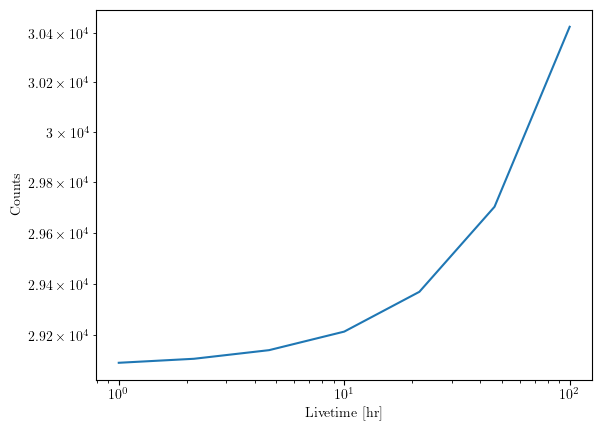

In [6]:
counts = []
for d in datasets_asimov:
    counts.append(d.counts.data.sum())
plt.plot(livetimes, counts)
plt.loglog()
plt.xlabel("Livetime [hr]")
plt.ylabel("Counts")


## Asimov Cases

In [7]:
true_energy = datasets_asimov[0].exposure.geom.axes[0].center.value


shift_neg = -0.1
shift_pos = +0.1
shift_cor = 0.0

tilt_neg = -0.015
tilt_pos = 0.015
tilt_cor = 0


bias, resolution = 0,0
print(tilt_neg)

-0.015


In [8]:
datasets_N = []
datasets_N_H0 = []

for d in datasets_asimov:
    sys_d_cor = sys_dataset(dataset_asimov= d,
                        shift = shift_cor, 
                        tilt = tilt_cor,
                        bias = bias,
                        resolution = resolution,
                        rnd = False,
                        e_reco_creation=10)
    dataset_cor_N = sys_d_cor.create_dataset_N(10)
    datasets_N.append(dataset_cor_N)
    dataset_cor_N = sys_d_cor.create_dataset_N(10)
    datasets_N_H0.append(dataset_cor_N)
        

In [9]:
zero = 1e-24
if tilt_pos == 0:
    tilt_assumed = zero
else:
    tilt_assumed = tilt_pos

## addional parameter bias and resolution (ereco) but are frozen
penalising_invcovmatrix = np.zeros((4, 4))
np.fill_diagonal(penalising_invcovmatrix,
                 [1/zero**2, 1/zero**2, 1/shift_pos**2, 1/tilt_assumed**2])
for i in range(len(datasets_N)):
    if tilt_assumed >zero:
        datasets_N[i].irf_model.eff_area_model.parameters['tilt_nuisance'].frozen = False
    datasets_N[i].penalising_invcovmatrix = penalising_invcovmatrix
    datasets_N[i].irf_model.e_reco_model.parameters.freeze_all()
for i in range(len(datasets_N_H0)):
    if tilt_assumed >zero:
        datasets_N_H0[i].irf_model.eff_area_model.parameters['tilt_nuisance'].frozen = False
    datasets_N_H0[i].penalising_invcovmatrix = penalising_invcovmatrix
    datasets_N_H0[i].irf_model.e_reco_model.parameters.freeze_all()
    datasets_N_H0[i].irf_model.parameters['tilt_nuisance'].frozen = False

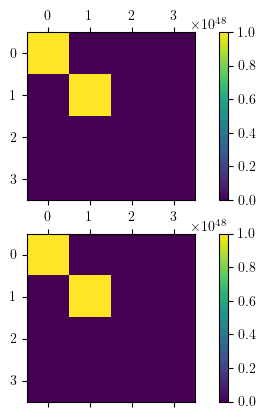

In [10]:
fig, ax = plt.subplots(2,1)
#ax = fig.add_subplot(111)
cax = ax[0].matshow(penalising_invcovmatrix)  # interpolation='nearest')
fig.colorbar(cax);
cax = ax[1].matshow(penalising_invcovmatrix)  # interpolation='nearest')
fig.colorbar(cax);

[]

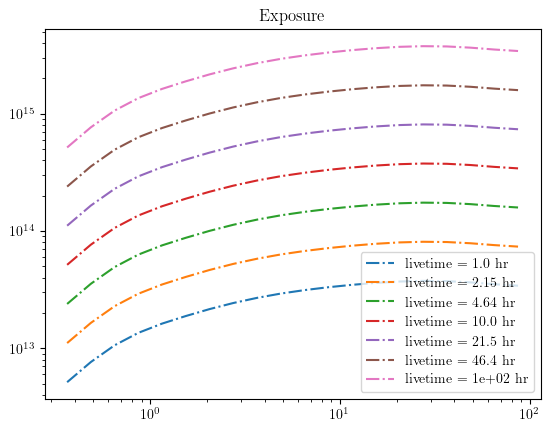

In [11]:
emask = dataset_cor_N.mask.data.sum(axis=2).sum(axis=1) >0 

e_bins = dataset_cor_N.geoms['geom'].axes[0].center.value[emask]

true_energy = dataset_cor_N.exposure.geom.axes[0].center.value[emask]
def sum_e(x):
    return x.sum(axis=2).sum(axis=1)[emask]

for i, d in enumerate(datasets_N):
    plt.plot(e_bins,sum_e(d.exposure.data ), label = f'livetime = {livetimes[i]:.3} hr', linestyle='-.')

plt.title("Exposure")
plt.legend()
plt.loglog()

[]

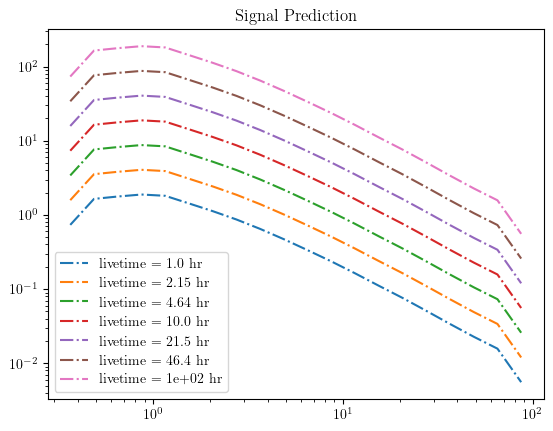

In [12]:
npred = []
for i, d in enumerate(datasets_N):
    plt.plot(e_bins,sum_e(d.npred_signal().data ), label = f'livetime = {livetimes[i]:.3} hr', linestyle='-.')
    npred.append(d.npred_signal().data.sum())
plt.title("Signal Prediction")
plt.legend()
plt.loglog()



[]

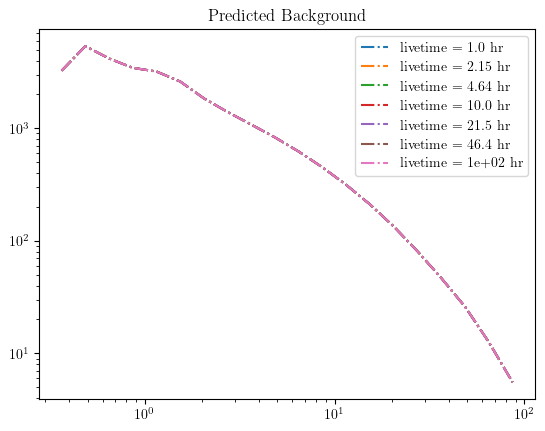

In [13]:
for i, d in enumerate(datasets_N):
    plt.plot(e_bins,sum_e(d.npred_background().data ), label = f'livetime = {livetimes[i]:.3} hr', linestyle='-.')

plt.title("Predicted Background")

plt.legend()
plt.loglog()

In [14]:
%%time
fitting = 0


if fitting:
    for i, d in enumerate(datasets_N):
        print(i)
        fit_cor = Fit(store_trace=True)
        result_cor = fit_cor.run(d)
    
        print("saving")
        path = f'data/8_model_nui_{shift_cor}_tilt_{tilt_cor}_livetime_{livetimes[i]}.yml'
        d.models.write(path,overwrite=True)
    
else:
    print("read")
    for i, d in enumerate(datasets_N):
        path = f'data/8_model_nui_{shift_cor}_tilt_{tilt_cor}_livetime_{livetimes[i]}.yml'
        datasets_N[i] = Dataset_load.load_dataset_N(d, path)        
        datasets_N[i].models.parameters['tilt_nuisance'].frozen = False 
    



read
CPU times: user 826 ms, sys: 298 ms, total: 1.12 s
Wall time: 1.13 s


In [15]:
print(datasets_N[0].models)

DatasetModels

Component 0: SkyModel

  Name                      : apkbo4qh
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.300   +/-    0.67             
    amplitude                     :   1.03e-12   +/- 9.7e-13 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lon_0                         :    329.680   +/-    0.05 deg         
    lat_0                         :    -30.222   +/-    0.05 deg         

Component 1: IRFModels

  Name                      : 4tAzUkUH-irf
  Datasets names            : 4tAzUkUH
  EReco  model type         : ERecoIRFModel
  Eff area  model type      : EffAreaIRFModel
  Parameters:
    bias                  (frozen):      0.000                   
    resolution            (frozen):      0.000                   
    norm_nuisance                 :

In [16]:
print("read")
datasets = []
for i, d in enumerate(datasets_N):
    path = f'data/8_model_{shift_cor}_tilt_{tilt_cor}_livetime_{livetimes[i]}.yml'
    da = Dataset_load.load_dataset(d, path)     
    datasets.append(da)

read


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1183: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(masked_verts[..., 0])
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1184: RuntimeWarning: All-NaN axis encountered
  maxx = np.nanmax(masked_verts[..., 0])
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


Text(0.5, 0, 'Signal Counts')

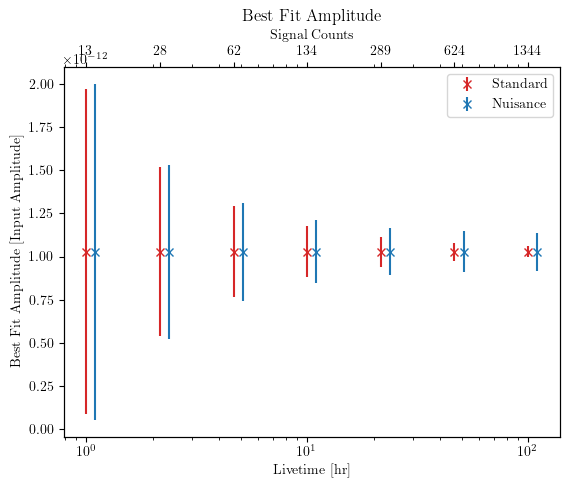

In [17]:
input_amplitude = scaled_amplitude.value  * 0.025
input_amplitude = 1
parname = 'amplitude'
for i, d in enumerate(datasets_N):
    par = datasets[i].models[0].parameters[parname]
    val, err = par.value, par.error
    plt.errorbar(livetimes[i], val/ input_amplitude, yerr = err/ input_amplitude,  fmt='x', color = 'tab:red')
    
    par = d.models[0].parameters[parname]
    val, err = par.value, par.error
    plt.errorbar( 1.1* livetimes[i] , val/ input_amplitude, yerr = err/ input_amplitude,  fmt='x', color = 'tab:blue')

plt.errorbar( np.nan, np.nan , yerr = np.nan, fmt='x', color = 'tab:red', label = 'Standard')
plt.errorbar( np.nan, np.nan , yerr = np.nan, fmt='x', color = 'tab:blue', label = 'Nuisance')
ax1 = plt.gca()
xlim = ax1.get_xlim()
#plt.hlines(1, xlim[0], xlim[1], color = 'grey')
plt.title("Best Fit Amplitude")
plt.legend()
plt.xscale('log')
plt.xlabel("Livetime [hr]")
plt.ylabel(f"Best Fit Amplitude [Input Amplitude]")

ax2 = ax1.twiny()
ax2.set_xscale("log")

ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(livetimes)
clabels = [ f'{int(c)}' for c in npred]
ax2.set_xticklabels(clabels)
ax2.set_xlabel(r"Signal Counts")


Text(0, 0.5, 'Best Fit Index []')

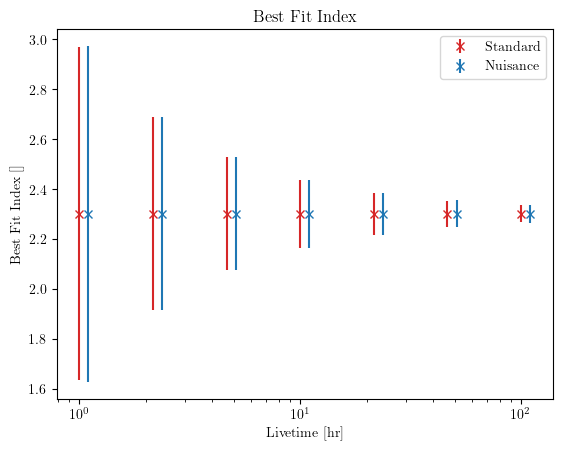

In [18]:
parname = 'index'
for i, d in enumerate(datasets_N):
    par = datasets[i].models[0].parameters[parname]
    val, err = par.value, par.error
    plt.errorbar(livetimes[i], val, yerr = err,  fmt='x', color = 'tab:red')
    
    par = d.models[0].parameters[parname]
    val, err = par.value, par.error
    plt.errorbar( 1.1* livetimes[i] , val, yerr = err,  fmt='x', color = 'tab:blue')
    
plt.errorbar( np.nan, np.nan , yerr = np.nan, fmt='x', color = 'tab:red', label = 'Standard')
plt.errorbar( np.nan, np.nan , yerr = np.nan, fmt='x', color = 'tab:blue', label = 'Nuisance')
    

plt.title("Best Fit Index")
plt.legend()
plt.xscale('log')
plt.xlabel("Livetime [hr]")
plt.ylabel(f"Best Fit Index [{par.unit}]")


## Significance

In [19]:
%%time
fitting = 0
if fitting:
    for i, d in enumerate(datasets_N_H0):
        print(i)
        datasets_N_H0[i].models.parameters['amplitude'].value = 1e-24
        datasets_N_H0[i].models.parameters['amplitude'].frozen  = True
        
        print("pre fit" , datasets_N_H0[i].models)
        fit_cor = Fit()
        result_cor = fit_cor.run(d)
        print("post" , datasets_N_H0[i])
        
        print(result_cor)
        
        print("saving")
        path = f'data/8_model_nui_H0_{shift_cor}_tilt_{tilt_cor}_livetime_{livetimes[i]}.yml'
        d.models.write(path,overwrite=True)
else:
    print("read")
    for i, d in enumerate(datasets_N_H0):
        path = f'data/8_model_nui_H0_{shift_cor}_tilt_{tilt_cor}_livetime_{livetimes[i]}.yml'
        datasets_N_H0[i]= Dataset_load.load_dataset_N(d, path)
        datasets_N_H0[i].penalising_invcovmatrix = penalising_invcovmatrix



read
CPU times: user 677 ms, sys: 212 ms, total: 890 ms
Wall time: 900 ms


In [20]:
datasets_H0 = []
print("read")
for i, d in enumerate(datasets_N):
    path = f'data/8_model_H0_{shift_cor}_tilt_{tilt_cor}_livetime_{livetimes[i]}.yml'
    datasets_H0.append(Dataset_load.load_dataset(d, path))

read


In [21]:
sig , sig_N = [], []
for i, l in enumerate(livetimes):
    H0 = datasets_H0[i].stat_sum()
    H1 = datasets[i].stat_sum()
    sig.append(np.sqrt(np.abs(H0- H1)))
    
    H0 = datasets_N_H0[i].stat_sum()
    H1 = datasets_N[i].stat_sum()
    sig_N.append(np.sqrt(np.abs(H0- H1)))
    

/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1183: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(masked_verts[..., 0])
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1184: RuntimeWarning: All-NaN axis encountered
  maxx = np.nanmax(masked_verts[..., 0])
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


Text(0.5, 0, 'Signal Counts')

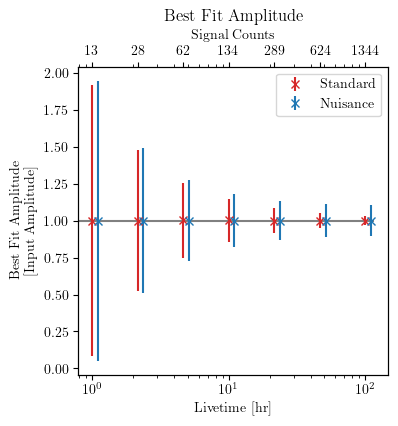

In [22]:
fig, (ax1) = plt.subplots(1,1, figsize = ((4,4)))

input_amplitude = scaled_amplitude.value # * 0.025
parname = 'amplitude'
for i, d in enumerate(datasets_N):
    par = datasets[i].models[0].parameters[parname]
    val, err = par.value, par.error
    ax1.errorbar(livetimes[i], val/ input_amplitude, yerr = err/ input_amplitude,  fmt='x', color = 'tab:red')
    
    par = d.models[0].parameters[parname]
    val, err = par.value, par.error
    ax1.errorbar( 1.1* livetimes[i] , val/ input_amplitude, yerr = err/ input_amplitude,  fmt='x', color = 'tab:blue')

ax1.errorbar( np.nan, np.nan , yerr = np.nan, fmt='x', color = 'tab:red', label = 'Standard')
ax1.errorbar( np.nan, np.nan , yerr = np.nan, fmt='x', color = 'tab:blue', label = 'Nuisance')
xlim = ax1.get_xlim()
ax1.hlines(1, xlim[0], xlim[1], color = 'grey')
ax1.set_title("Best Fit Amplitude")
ax1.legend()
ax1.set_xscale('log')
ax1.set_xlabel("Livetime [hr]")
ax1.set_ylabel(f"Best Fit Amplitude \n[Input Amplitude]")

ax1a = ax1.twiny()
ax1a.set_xscale("log")

ax1a.set_xlim(ax1.get_xlim())
ax1a.set_xticks(livetimes)
clabels = [ f'{int(c)}' for c in npred]
ax1a.set_xticklabels(clabels)
ax1a.set_xlabel(r"Signal Counts")



## End Plot

Text(0, 0.5, 'Signifiance \n[$\\sigma$]')

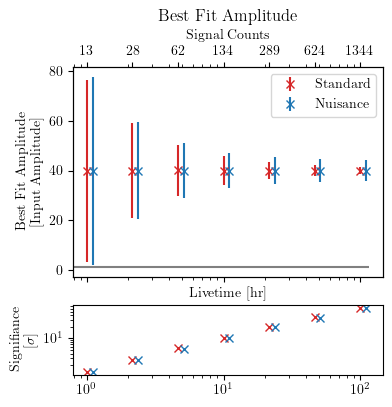

In [23]:
fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw={'height_ratios': [3, 1]},
                         sharex = True, figsize = ((4,4)))

input_amplitude = scaled_amplitude.value  * 0.025
parname = 'amplitude'
for i, d in enumerate(datasets_N):
    par = datasets[i].models[0].parameters[parname]
    val, err = par.value, par.error
    ax1.errorbar(livetimes[i], val/ input_amplitude, yerr = err/ input_amplitude,  fmt='x', color = 'tab:red')
    
    par = d.models[0].parameters[parname]
    val, err = par.value, par.error
    ax1.errorbar( 1.1* livetimes[i] , val/ input_amplitude, yerr = err/ input_amplitude,  fmt='x', color = 'tab:blue')

ax1.errorbar( np.nan, np.nan , yerr = np.nan, fmt='x', color = 'tab:red', label = 'Standard')
ax1.errorbar( np.nan, np.nan , yerr = np.nan, fmt='x', color = 'tab:blue', label = 'Nuisance')
xlim = ax1.get_xlim()
ax1.hlines(1, xlim[0], xlim[1], color = 'grey')
ax1.set_title("Best Fit Amplitude")
ax1.legend()
ax1.set_xscale('log')
ax1.set_xlabel("Livetime [hr]")
ax1.set_ylabel(f"Best Fit Amplitude \n[Input Amplitude]")

ax1a = ax1.twiny()
ax1a.set_xscale("log")

ax1a.set_xlim(ax1.get_xlim())
ax1a.set_xticks(livetimes)
clabels = [ f'{int(c)}' for c in npred]
ax1a.set_xticklabels(clabels)
ax1a.set_xlabel(r"Signal Counts")


ax2.errorbar( np.nan, np.nan , yerr = np.nan, fmt='x', color = 'tab:red', label = 'Standard')
ax2.errorbar( np.nan, np.nan , yerr = np.nan, fmt='x', color = 'tab:blue', label = 'Nuisance')

ax2.plot(livetimes, sig, linestyle = '', marker = 'x', color = 'tab:red')
ax2.plot(livetimes*1.1, sig_N, linestyle = '', marker = 'x', color = 'tab:blue')
ax2.loglog()
ax2.set_ylabel("Signifiance \n[$\sigma$]")               